# Assessing effects of air pollution on cognition

## 1. Preprocess data

In [1]:
import pandas as pd
import os
import numpy as np
from mihm.hyperparam.preprocess import preprocess

In [2]:
base_dir = "/app/projects"
results_dir = os.path.join(base_dir, "results/Jul30_2024_Cognition_PM25")
os.makedirs(results_dir, exist_ok=True)
data_dir = os.path.join(base_dir, "data/original")

In [3]:
data_path = os.path.join(data_dir, 'HRSCog2016_pm25.dta')
# read model and rename cols
read_cols = [
    #outcome
    "cog272016",
    #individual-level sociodemographic
    "agey2016", "female", "racethn", "edug", "lg_inc2016", "ihs_wealthf2016",
    #individual-level physiological
    "bmi2016", "strok2016", "hibp2016", "diab2016", "heart2016", "lung2016", "depres2016", "ltactx2016", "mdactx2016", "vgactx2016",
    #community-level
    "affluence", "deprivation",#"pedlt1418", "pedba1418", "punem1418", "pocmp1418", "phpas1418", "pfvwc1418", "pown1418", "mhval1418", "mhinc1418",
    #"affluence", "deprivation", 
    "rural", "green", 
    # environmental hazards
    "m_pm_30d",
    # survey weights
    "svwt"
]
change_name_list = [
    # outcome
    "cognition",
    #individual-level sociodemographic
    "age", "gender (bin)", "race/ethnicity (cat)", "education category (ord)", "[log] household income", "[ihs] non-housing financial wealth", 
    #individual-level physiological
    "bmi", "stroke (bin)", "hypertension (bin)", "diabetes (bin)", "heart disease (bin)", "lung disease (bin)", "depression (bin)", "light activity (ord)", "moderate activity (ord)", "vigorous activity (ord)", 
    #community-level
    "affluence", "deprivation", #[25+] percent without high school degree", "[25+] percent college graduates", "percent unemployment", "percent in management, professional, and related", "percent households with public assistance income", "percent families with children and in poverty", "percent homeowners", "median house value", "median household income", 
    #"affluence", "deprivation", 
    "Urban / Rural (bin)", "greenness score", 
    #hazards
    "mean air pollution (pm2.5) over 30 days", 
    #survey weights
    "svwt"
]
assert len(read_cols) == len(change_name_list)

rename_dict = dict(zip(read_cols, change_name_list))
reverse_rename_dict = dict(zip(change_name_list, read_cols))

interactor_col = "mean air pollution (pm2.5) over 30 days"
outcome_col = "cognition"
controlled_cols = [
    'mean air pollution (pm2.5) over 30 days'
]
interaction_predictors = [
    #individual-level sociodemographic
    "age", "gender (bin)", "race/ethnicity (cat)", "education category (ord)", "[log] household income", "[ihs] non-housing financial wealth", 
    #individual-level physiological
    "bmi", "stroke (bin)", "hypertension (bin)", "diabetes (bin)", "heart disease (bin)", "lung disease (bin)", "depression (bin)", "light activity (ord)", "moderate activity (ord)", "vigorous activity (ord)", 
    #community-level
    "affluence", "deprivation",#[25+] percent without high school degree", "[25+] percent college graduates", "percent unemployment", "percent in management, professional, and related", "percent households with public assistance income", "percent families with children and in poverty", "percent homeowners", "median house value", "median household income", 
    #"affluence", "deprivation", 
    "Urban / Rural (bin)", "greenness score", 
]

# define variable types for preprocessing
categorical_cols = [colname for colname in change_name_list if colname.endswith("(cat)")]
binary_cols = [colname for colname in change_name_list if colname.endswith("(bin)")]
ordinal_cols = [colname for colname in change_name_list if colname.endswith("(ord)")]
continuous_cols = [colname for colname in change_name_list 
                   if not colname.endswith("(ord)") and not colname.endswith("(cat)") and not colname.endswith("(bin)") and colname!="svwt"]

In [ ]:
# compile stata regression command to evaluate the model each epoch during training
regress_cmd = "regress {} {} c.{}#c.{}".format(reverse_rename_dict[outcome_col], reverse_rename_dict[interactor_col], reverse_rename_dict[interactor_col], "res_index")
for c in controlled_cols[1:]:
    regress_cmd += " {}".format(reverse_rename_dict[c])
for c in interaction_predictors:
    if "(bin)" in c or "(cat)" in c:
        regress_cmd += " i.{}".format(reverse_rename_dict[c])
    else:
        regress_cmd += " {}".format(reverse_rename_dict[c])
regress_cmd += " [pweight=svwt]"
print(regress_cmd)

regress cog272016 m_pm_30d c.m_pm_30d#c.res_index agey2016 i.female i.racethn edug lg_inc2016 ihs_wealthf2016 bmi2016 i.strok2016 i.hibp2016 i.diab2016 i.heart2016 i.lung2016 i.depres2016 ltactx2016 mdactx2016 vgactx2016 affluence deprivation i.rural green [pweight=svwt]


In [ ]:
df_orig, airpol_dataset = preprocess(
    data_path,
    read_cols,
    rename_dict,
    binary_cols,
    categorical_cols,
    ordinal_cols,
    continuous_cols,
    interactor_col,
    outcome_col,
    controlled_cols,
    interaction_predictors,
    "svwt"
)

In [ ]:
print("Mean and std of standardized predictors: ", airpol_dataset.mean_std_dict)

Mean and std of standardized predictors:  {'cognition': (15.056205588502431, 4.449443340681803), 'age': (65.29871240049154, 11.481660900125831), '[log] household income': (10.459803, 1.8698359727859497), '[ihs] non-housing financial wealth': (4.399201, 8.572608947753906), 'bmi': (29.070486723299677, 6.338849322417417), 'affluence': (0.00025136524, 0.95445716381073), 'deprivation': (-0.006096172, 0.8757331967353821), 'greenness score': (35.631866, 34.81218719482422), 'mean air pollution (pm2.5) over 30 days': (8.324667, 2.187854528427124), 'education category (ord)': (1.6039963669391462, 1.0247738367702612), 'light activity (ord)': (2.3762889351926058, 1.0850948881541782), 'moderate activity (ord)': (2.055617887481968, 1.2836432513543141), 'vigorous activity (ord)': (1.0996420366511728, 1.32505826995149)}


### 2. Prepare data for ReGNN training (70/30 divide)

In [ ]:
from mihm.data.trainutils import train_test_split
if not os.path.exists(os.path.join(results_dir, "train_test_idxs.npz")):
    print("Creating train, test split")
    train_idx, test_idx = train_test_split(len(airpol_dataset))
    print("Train size: ", len(train_idx))
    print("Test size: ", len(test_idx))
    # save train, test, val index
    np.savez(os.path.join(results_dir, "train_test_idxs.npz"), train_idx=train_idx, test_idx=test_idx)
else:
    print("Loading train, test split")
    idxs = np.load(os.path.join(results_dir, "train_test_idxs.npz"))
    train_idx = idxs["train_idx"]
    test_idx = idxs["test_idx"]

Loading train, test split


In [ ]:
train_heat_dataset = airpol_dataset.get_subset(train_idx)
test_heat_dataset = airpol_dataset.get_subset(test_idx)

## 3. Train ReGNN model

In [9]:
from mihm.hyperparam.train import train_mihm
import torch

In [ ]:
hidden_layer_sizes = [30, 10, 2, 1]
vae=False # if True, use VAE loss
vae_loss = False
var_reg = 0.1
svd=False # dimensionality reduction with SVD before input to ReGNN
k_dims=25 # only necessary if svd=True
epochs=200
batch_size=800
lr=0.005
weight_decay_lr=0.01 # L2 regularization on the linear regression coefficients
weight_decay_nn=0.01 # L2 regularization on the neural network parameters
shuffle=True
evaluate=True # evaluate the model on the test set during training using stata
dropout=0.5
n_models=5
elasticnet=False # use elastic net regularization
lambda_reg = 0.1 # if using L1 or elastic net, this is the weight on the regularization penalty
survey_weights = True # use weighted MSE using survey weights
all_interaction_predictors = airpol_dataset.to_tensor(device="cpu")["interaction_predictors"]
eval_epoch = 20 # evaluate the model every eval_epoch epochs
include_bias_focal_predictor=False # include the bias term in the focal predictor (i.e. for extreme heat, you want to focus on temps larger than some threshold.)
model_name = "CognitionPM25_0_01WD_NoEN_5Ensemble_0_5DO"

In [ ]:
# this is a master training script (see hyperparam/train.py for details)
model, traj_data = train_mihm(
    airpol_dataset,
    train_heat_dataset,
    hidden_layer_sizes,
    vae,
    svd,
    k_dims,
    epochs,
    batch_size,
    lr,
    weight_decay_lr,
    weight_decay_nn,
    regress_cmd,
    include_bias_focal_predictor=include_bias_focal_predictor,
    shuffle=shuffle,
    evaluate=evaluate,
    eval_epoch=eval_epoch,
    df_orig=df_orig,
    file_id=1,
    use_stata=True,
    return_trajectory=True,
    vae_loss=vae_loss,
    vae_lambda=var_reg,
    dropout=dropout,
    test_mihm_dataset=test_heat_dataset,
    get_testset_results=True,
    elasticnet=elasticnet,
    lambda_reg=lambda_reg,
    n_models=n_models,
    survey_weights=survey_weights,
)

In [ ]:
# export model performance trajectory and final model
import pickle
with open(os.path.join(results_dir, 'traj_data_{}.pkl'.format(model_name)), 'wb') as f:
    pickle.dump(traj_data, f)
torch.save(model, os.path.join(results_dir, 'model_{}.pt'.format(model_name)))

## Results 1. graph performance trajectory of the model

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
with open(os.path.join(results_dir, 'traj_data_{}.pkl'.format(model_name)), 'rb') as f:
    traj_data_loaded = pickle.load(f)

In [ ]:
figpath = results_dir
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_data = np.arange(1, len(traj_data_loaded))
train_loss = [data["train_loss"] for data in traj_data_loaded[1:]]
test_loss = [data["test_loss"] for data in traj_data_loaded[1:]]
p_val = np.array([data["regression_summary"]["interaction term p value"] for data in traj_data_loaded[1:]])
adj_rsq = np.array([data["regression_summary"]["adjusted r squared"] for data in traj_data_loaded[1:]])
p_val_test = np.array([data["regression_summary_test"]["interaction term p value"] for data in traj_data_loaded[1:]])
adj_rsq_test = np.array([data["regression_summary_test"]["adjusted r squared"] for data in traj_data_loaded[1:]])

ax[0].plot(x_data, train_loss, label="train loss", color="orange")
ax[0].plot(x_data, test_loss, label="test_loss", color='purple')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train loss", "Test loss"], loc="upper right")

# plot pval and rsq
pval1 = ax[1].plot(x_data, p_val, label="Train set p-value", color="blue")
pval2 = ax[1].plot(x_data, p_val_test, label="Test set p-value", color="blue", linestyle="dashed")

ax[1].set_ylabel("Interaction term p-value", color="blue")
ax[1].tick_params(axis='y', labelcolor="blue")
ax2 = ax[1].twinx()
rsq1 = ax2.plot(x_data, adj_rsq, label="Train set adjusted r-squared", color="red")
rsq2 = ax2.plot(x_data, adj_rsq_test, label="Test set adjusted r-squared", color="red", linestyle="dashed")

ax2.set_ylabel("Adjusted r-squared", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylim([0.305, 0.335])
ax2.spines['left'].set_color("blue")
ax2.spines['right'].set_color("red")
ax[1].set_xlabel("Epochs")
all_lines = pval1+pval2+rsq1+rsq2
labels = [l.get_label() for l in all_lines]
ax[1].legend(all_lines, labels, loc="upper right")
# fig.legend(["train_loss", "test_loss", "p_val"], loc="upper right")
fig.suptitle("{}".format(model_name))
fig.savefig(os.path.join(figpath, "traj_{}.png".format(model_name)))


## Results 2. Produce summary indices from all sample using trained model

In [17]:
from mihm.model.mihm import IndexPredictionModel
import matplotlib.pyplot as plt
import torch

In [18]:
model_index = model.index_prediction_model
model_index.eval()

IndexPredictionModel(
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (mlp): MLPEnsemble(
    (models): ModuleList(
      (0-4): 5 x MLP(
        (dropout): Dropout(p=0.5, inplace=False)
        (layers): ModuleList(
          (0): Linear(in_features=22, out_features=30, bias=True)
          (1): Linear(in_features=30, out_features=10, bias=True)
        )
        (output_layer): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
  (final): Linear(in_features=2, out_features=1, bias=True)
)

In [59]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = train_heat_dataset.to_tensor(device="cpu")["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

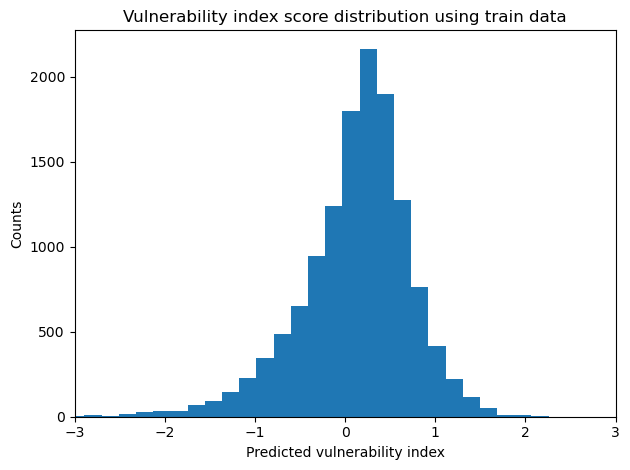

In [60]:
fig, ax = plt.subplots()
ax.hist(all_resilience_index, bins=50)
ax.set_xlabel("Predicted vulnerability index")
ax.set_ylabel("Counts")
ax.set_title("Vulnerability index score distribution using train data".format(model_name))
ax.set_xlim([-3, 3])
fig.tight_layout()
fig.savefig(os.path.join(figpath, "vulnerability_index_dist_{}_train.png".format(model_name)))

In [57]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = test_heat_dataset.to_tensor()["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

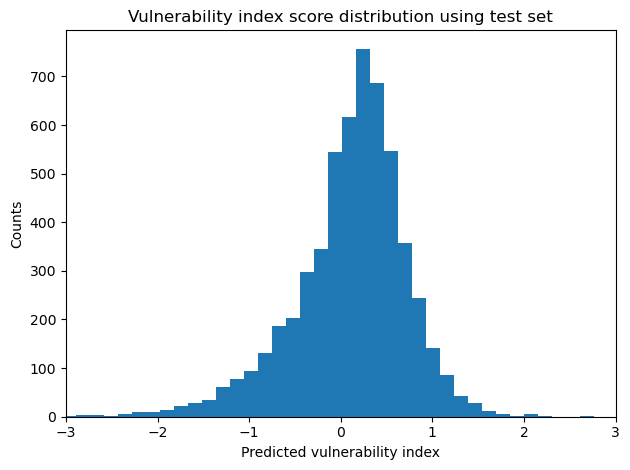

In [58]:
fig, ax = plt.subplots()
ax.hist(all_resilience_index, bins=50)
ax.set_xlabel("Predicted vulnerability index")
ax.set_ylabel("Counts")
ax.set_title("Vulnerability index score distribution using test set".format(model_name))
ax.set_xlim([-3, 3])
fig.tight_layout()
fig.savefig(os.path.join(figpath, "vulnerability_index_dist_{}_test.png".format(model_name)))

## Results 3. Run moderated multiple regression using the produced indices on Stata

In [ ]:
# replace with your own path, where the produced index is saved as "res_index" variable in the dataset
save_name = "/app/projects/mihm/temp/data/index_prediction_2.dta" 

In [24]:
import stata_setup
stata_setup.config("/usr/local/stata17", "mp")
from pystata import stata
import pandas as pd

In [ ]:
# regression command for twin-ReGNN regression model
regress_cmd = "regress cog272016 m_pm_30d c.m_pm_30d#c.res_index agey2016 i.female i.racethn edug lg_inc2016 ihs_wealthf2016 bmi2016 i.strok2016 i.hibp2016 i.diab2016 i.heart2016 i.lung2016 i.depres2016 ltactx2016 mdactx2016 vgactx2016 affluence deprivation i.rural green [pweight=svwt]"
# regression command for regression model that include all interaction terms with air pollution
regress_cmd2 = "regress cog272016 m_pm_30d c.agey2016##c.m_pm_30d i.female##c.m_pm_30d i.racethn##c.m_pm_30d c.edug##c.m_pm_30d c.lg_inc2016##c.m_pm_30d c.ihs_wealthf2016##c.m_pm_30d c.bmi2016##c.m_pm_30d i.strok2016##c.m_pm_30d i.hibp2016##c.m_pm_30d i.diab2016##c.m_pm_30d i.heart2016##c.m_pm_30d i.lung2016##c.m_pm_30d i.depres2016##c.m_pm_30d c.ltactx2016##c.m_pm_30d c.mdactx2016##c.m_pm_30d c.vgactx2016##c.m_pm_30d c.affluence##c.m_pm_30d c.deprivation##c.m_pm_30d i.rural##c.m_pm_30d c.green##c.m_pm_30d [pweight=svwt]"

In [ ]:
# check variance inflation factor of ReGNN model
stata.run(regress_cmd)
stata.run("vif")
out = stata.get_return()

(sum of wgt is 1,540,341.29142)

Linear regression                               Number of obs     =     18,717
                                                F(24, 18692)      =     351.95
                                                Prob > F          =     0.0000
                                                R-squared         =     0.3148
                                                Root MSE          =      3.634

------------------------------------------------------------------------------
             |               Robust
   cog272016 | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
    m_pm_30d |  -.0402178   .0126273    -3.18   0.001    -.0649685   -.0154671
             |
  c.m_pm_30d#|
 c.res_index |   .0422111   .0063573     6.64   0.000     .0297502    .0546719
             |
    agey2016 |  -.0861159   .0029707   -28.99   0.000    -.0919386   -.0802931
             |
 

In [ ]:
# check vif of regression model that include all interaction terms with air pollution
stata.run(regress_cmd2)
stata.run("vif")
out = stata.get_return()

(sum of wgt is 1,540,341.29142)
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.
note: m_pm_30d omitted because of collinearity.

Linear 

## Results 4. Make margins plot to visualize the interaction effect of the produced summary index (res_index).

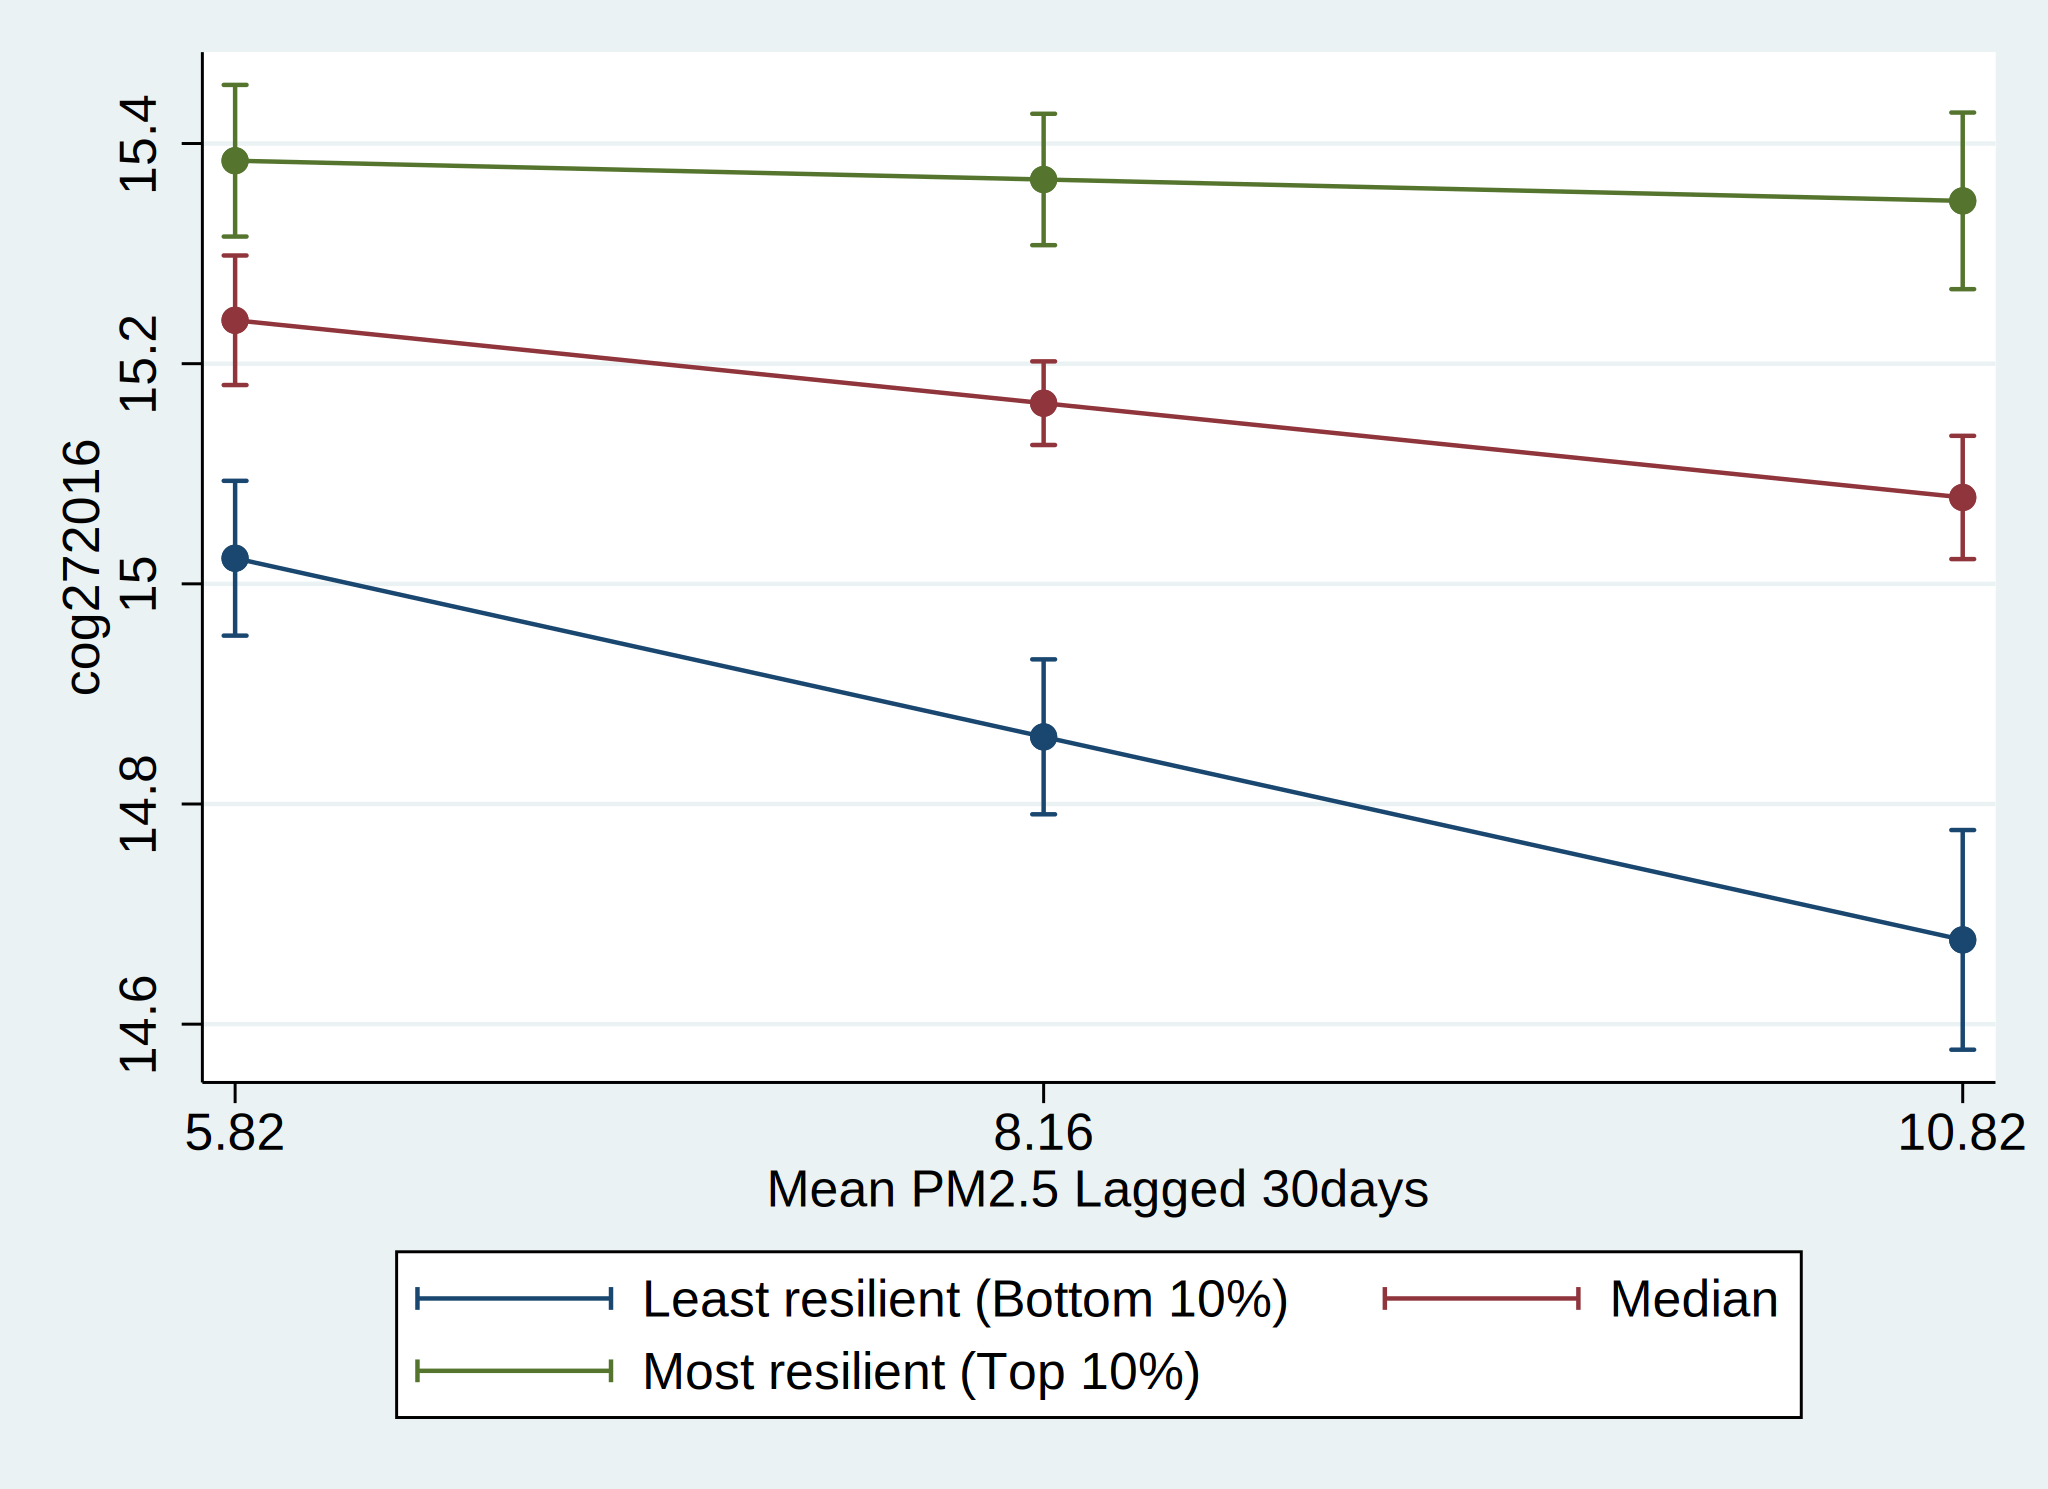

In [31]:
import numpy as np

bottom10 = np.quantile(all_resilience_index, 0.1)
median = np.quantile(all_resilience_index, 0.5)
top10 = np.quantile(all_resilience_index, 0.9)

bottom10_pm = np.quantile(df_orig['m_pm_30d'], 0.1)
median_pm = np.quantile(df_orig['m_pm_30d'], 0.5)
top10_pm = np.quantile(df_orig['m_pm_30d'], 0.9)

jump = abs(top10-bottom10)/2
margins_cmd = "margins, at(m_pm_30d =({:.2f} {:.2f} {:.2f}) res_index=({:.2f} {:.2f} {:.2f}) ) atmeans".format(bottom10_pm, median_pm, top10_pm, bottom10, median, top10)
margins_plt_cmd = 'marginsplot, level(83.4) xtitle("Mean PM2.5 Lagged 30days") ytitle("{}") title("") legend(order(1 "Least resilient (Bottom 10%)" 2 "Median" 3 "Most resilient (Top 10%)"))'.format(read_cols[0])
stata.run(margins_cmd, quietly=True)
stata.run(margins_plt_cmd, quietly=True)
stata.run('graph export {}, replace'.format(os.path.join(figpath, "ml_vul_PC_age_interaction.png")), quietly=True)  # Save the figure

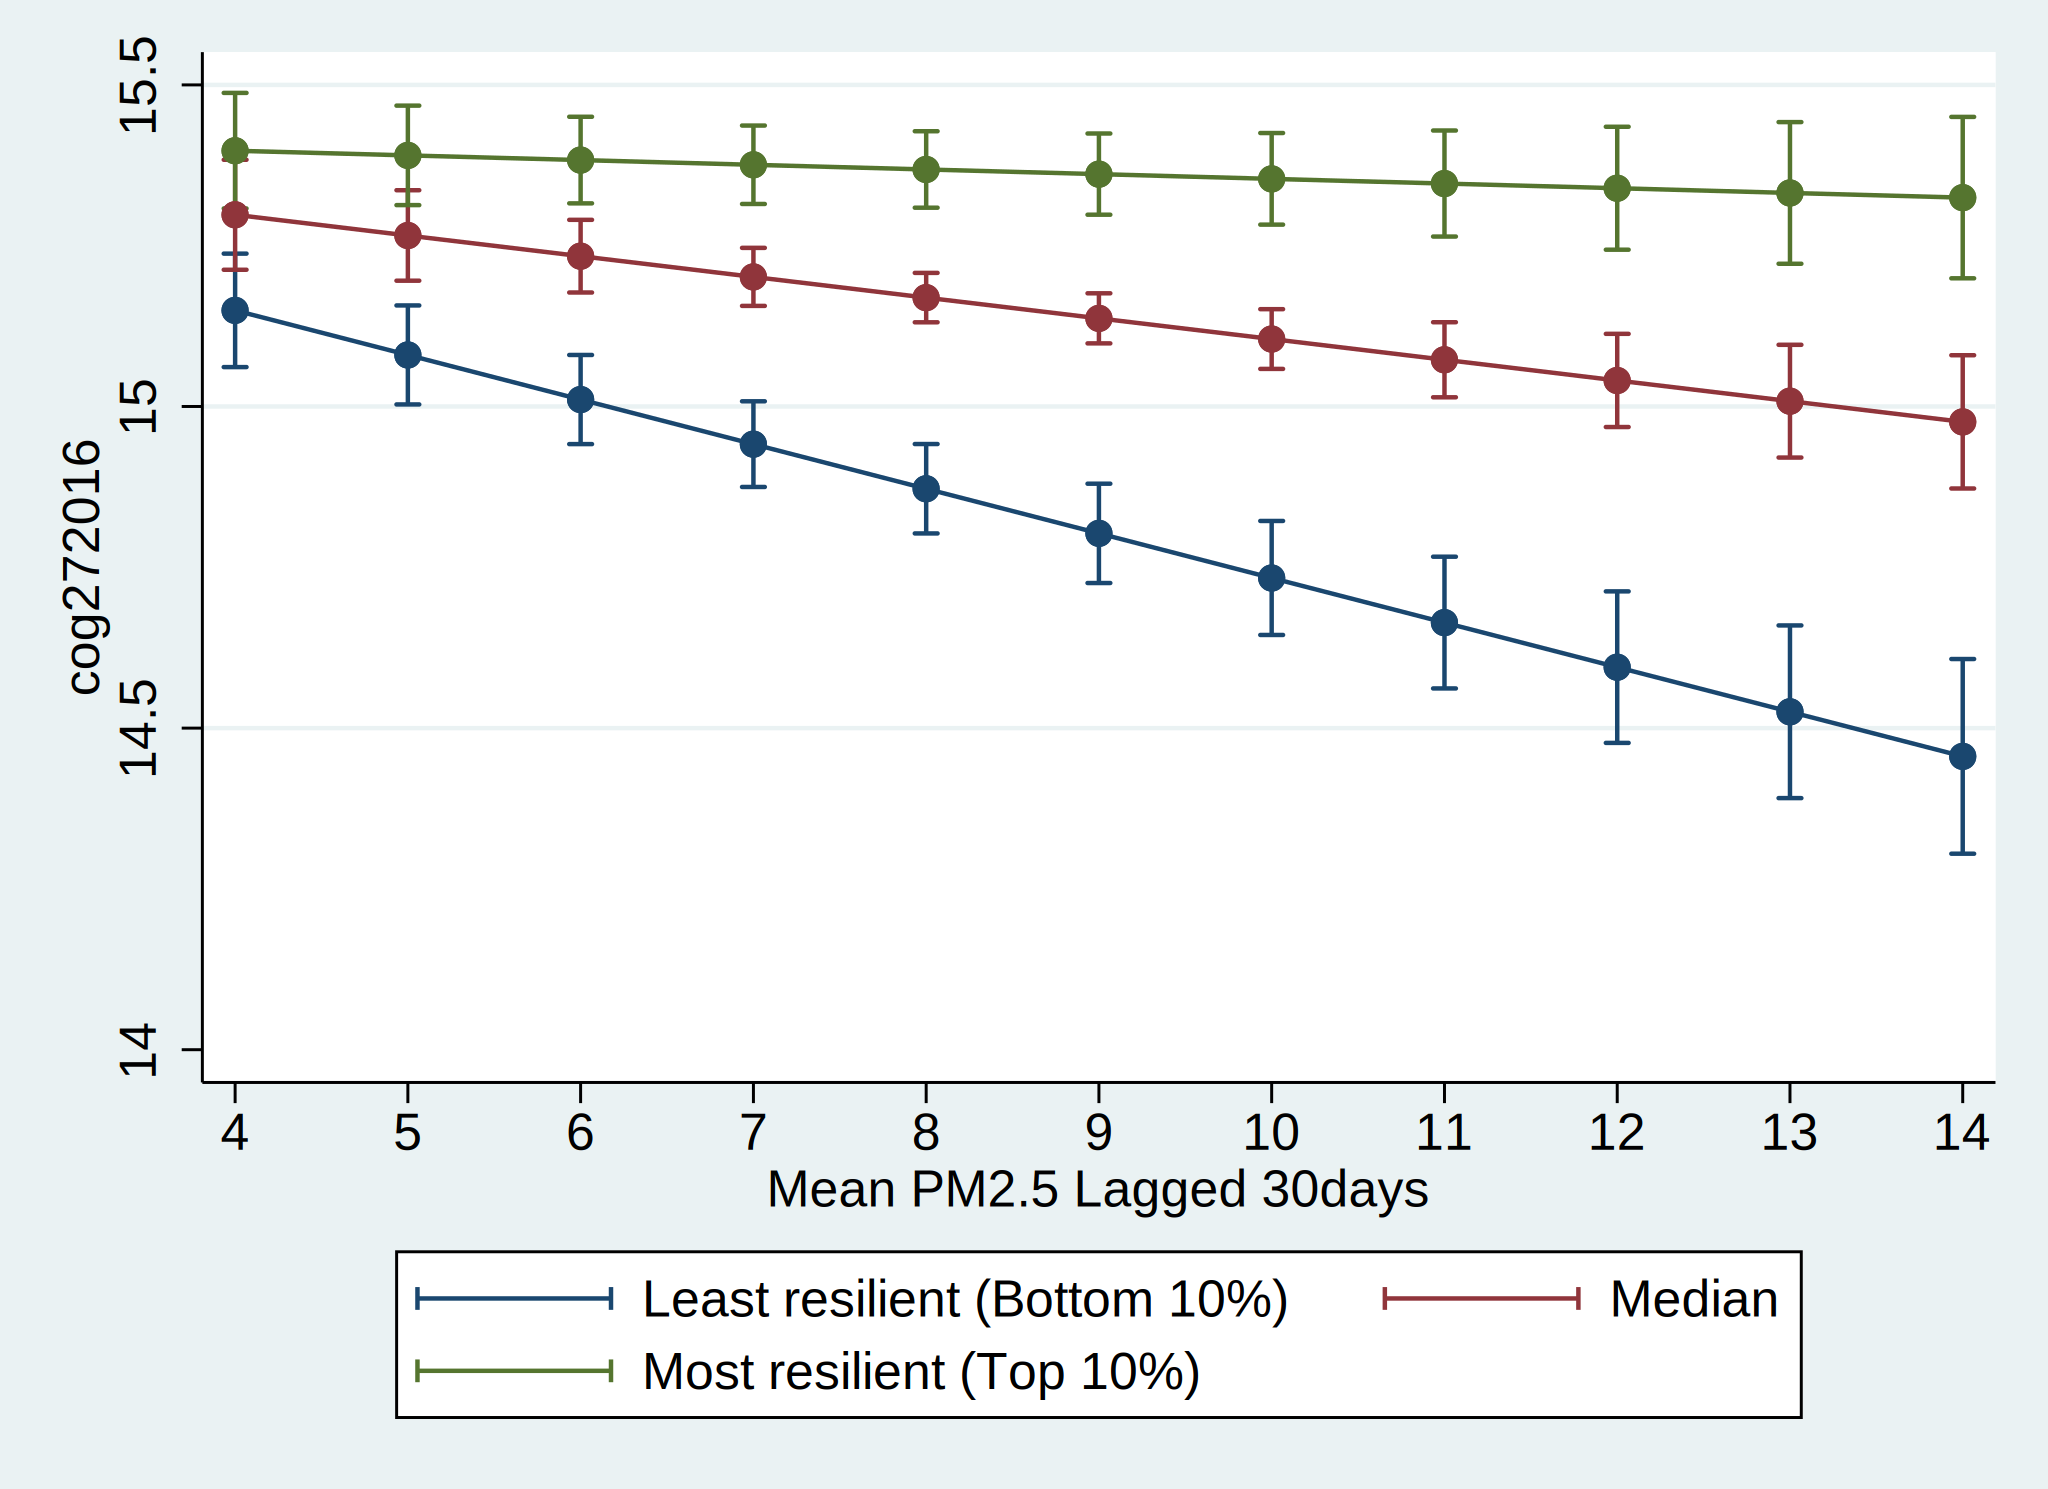

In [33]:
margins_cmd = "margins, at(m_pm_30d =(4(1)14) res_index=({:.2f} {:.2f} {:.2f}) ) atmeans".format(bottom10, median, top10)
margins_plt_cmd = 'marginsplot, level(83.4) xtitle("Mean PM2.5 Lagged 30days") ytitle("{}") title("") legend(order(1 "Least resilient (Bottom 10%)" 2 "Median" 3 "Most resilient (Top 10%)"))'.format(read_cols[0])
stata.run(margins_cmd, quietly=True)
stata.run(margins_plt_cmd, quietly=True)
stata.run('graph export {}, replace'.format(os.path.join(figpath, "ml_interaction_pm25.png")), quietly=True)  # Save the figure

## Results 5. Decompose ReGNN model using partial dependence and accumulated local effect plot

In [ ]:
from mihm.model.modelutils import SklearnCompatibleModel
from alibi.explainers import ALE, plot_ale

In [ ]:
sk_model_index = SklearnCompatibleModel(model_index, device="cuda:0")
sk_model_index.fit(None, None)

SklearnCompatibleModel(device='cuda:0',
                       model=IndexPredictionModel(
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (mlp): MLPEnsemble(
    (models): ModuleList(
      (0-4): 5 x MLP(
        (dropout): Dropout(p=0.5, inplace=False)
        (layers): ModuleList(
          (0): Linear(in_features=22, out_features=30, bias=True)
          (1): Linear(in_features=30, out_features=10, bias=True)
        )
        (output_layer): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
  (final): Linear(in_features=2, out_features=1, bias=True)
))

In [ ]:
airpol_dataset.interaction_predictors

['age',
 'gender (bin)',
 'education category (ord)',
 '[log] household income',
 '[ihs] non-housing financial wealth',
 'bmi',
 'stroke (bin)',
 'hypertension (bin)',
 'diabetes (bin)',
 'heart disease (bin)',
 'lung disease (bin)',
 'depression (bin)',
 'light activity (ord)',
 'moderate activity (ord)',
 'vigorous activity (ord)',
 'affluence',
 'deprivation',
 'Urban / Rural (bin)',
 'greenness score',
 'race/ethnicity (cat)_1. NHB',
 'race/ethnicity (cat)_2. Hispanic',
 'race/ethnicity (cat)_3. Others']

In [ ]:
feature_names = ["age", "sex [female=1]", "educational attainment", "household income (log)", "non-housing financial wealth (ihs)", 
                "bmi", "stroke", "hypertension", "diabetes", "heart disease", "lung disease", "depression", "light activity", "moderate activity", "vigorous activity", 
                "affluence", "deprivation", "urban / rural [rural=1]", "greenness score", "non-hispanic black", "hispanic", "other ethnicity"]

In [ ]:
ale = ALE(sk_model_index.predict, feature_names=feature_names[:21], target_names=["resilience index"])
np_dataset = airpol_dataset.to_numpy()
X = np_dataset["interaction_predictors"]
y = np_dataset["outcome"]
exp = ale.explain(X)

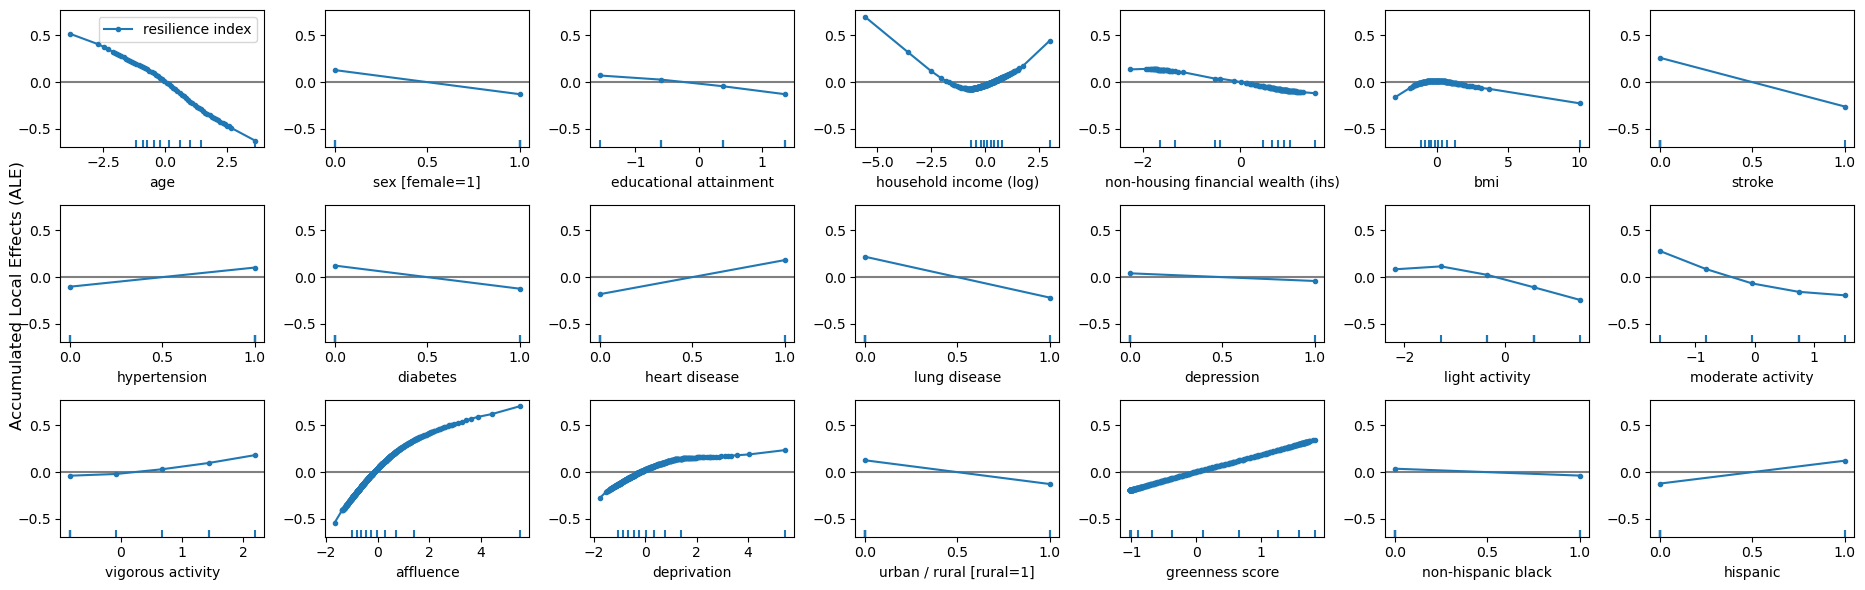

In [ ]:
results = plot_ale(exp, n_cols=7, fig_kw={'figwidth':19, 'figheight':6})
for axes in results:
    for ax in axes:
        ax.set_ylabel("")
fig = plt.gcf()
fig.supylabel("Accumulated Local Effects (ALE)")
fig.tight_layout()
fig.savefig(os.path.join(results_dir, "ale.png"))

In [ ]:
from artemis.importance_methods.model_agnostic import PartialDependenceBasedImportance
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

In [ ]:
df = airpol_dataset.df[interaction_predictors]
friedman = FriedmanHStatisticMethod()
friedman.fit(sk_model_index, df, show_progress=True, batchsize=10000, n=1000)

Calculating one vs all interactions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:17<00:00,  6.27s/it]


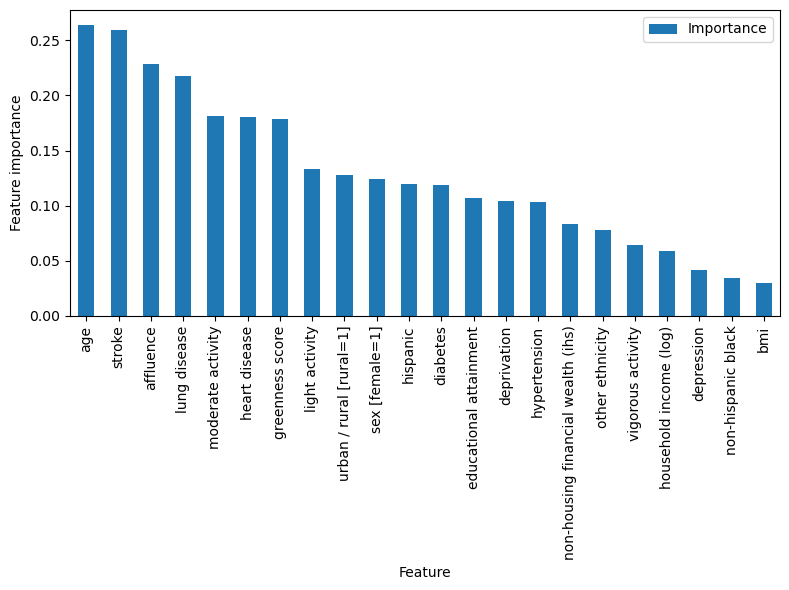

In [ ]:
friedman.feature_importance.plot.bar(x="Feature", y="Importance", figsize=(8, 6))
features_by_importance = friedman.feature_importance.Feature
figure = plt.gcf()
ax = plt.gca()
xlabels = [feature_names[interaction_predictors.index(f_orig)] for f_orig in features_by_importance]
ax.set_xticklabels(xlabels)

ax.set_ylabel("Feature importance")
figure.tight_layout()
figure.savefig(os.path.join(results_dir, "importance.png"))

In [ ]:
interaction_feat1 = [interaction_predictors.index(f) for f in friedman.ovo["Feature 1"]]
interaction_feat2 = [interaction_predictors.index(f) for f in friedman.ovo["Feature 2"]]
interactions = [*zip(interaction_feat1, interaction_feat2)]

In [ ]:
friedman.feature_importance.to_csv(os.path.join(results_dir, "regnn_importance.csv"))

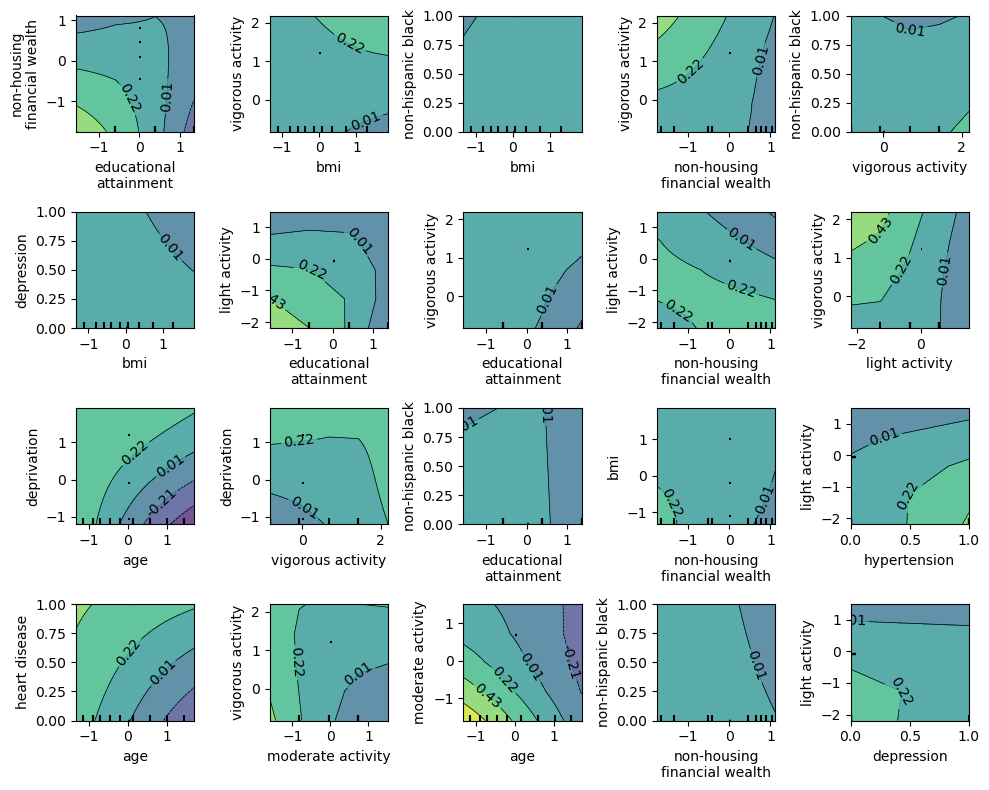

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
feature_names = ["age", "sex [female=1]", "educational\nattainment", "household income", "non-housing\nfinancial wealth", 
                "bmi", "stroke", "hypertension", "diabetes", "heart disease", "lung disease", "depression", "light activity", "moderate activity", "vigorous activity", 
                "affluence", "deprivation", "urban / rural [rural=1]", "greenness score", "non-hispanic black", "hispanic", "other ethnicity"]
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
sk_model_index._model.to("cuda:0")
PartialDependenceDisplay.from_estimator(sk_model_index, heat_dataset.df[interaction_predictors], features=interactions[:20], ax=axes, grid_resolution=50)
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_xlabel(feature_names[interactions[i*5+j][0]])
        ax.set_ylabel(feature_names[interactions[i*5+j][1]])
fig.tight_layout()
fig.savefig(os.path.join(results_dir, "interactions_regnn.png"))

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


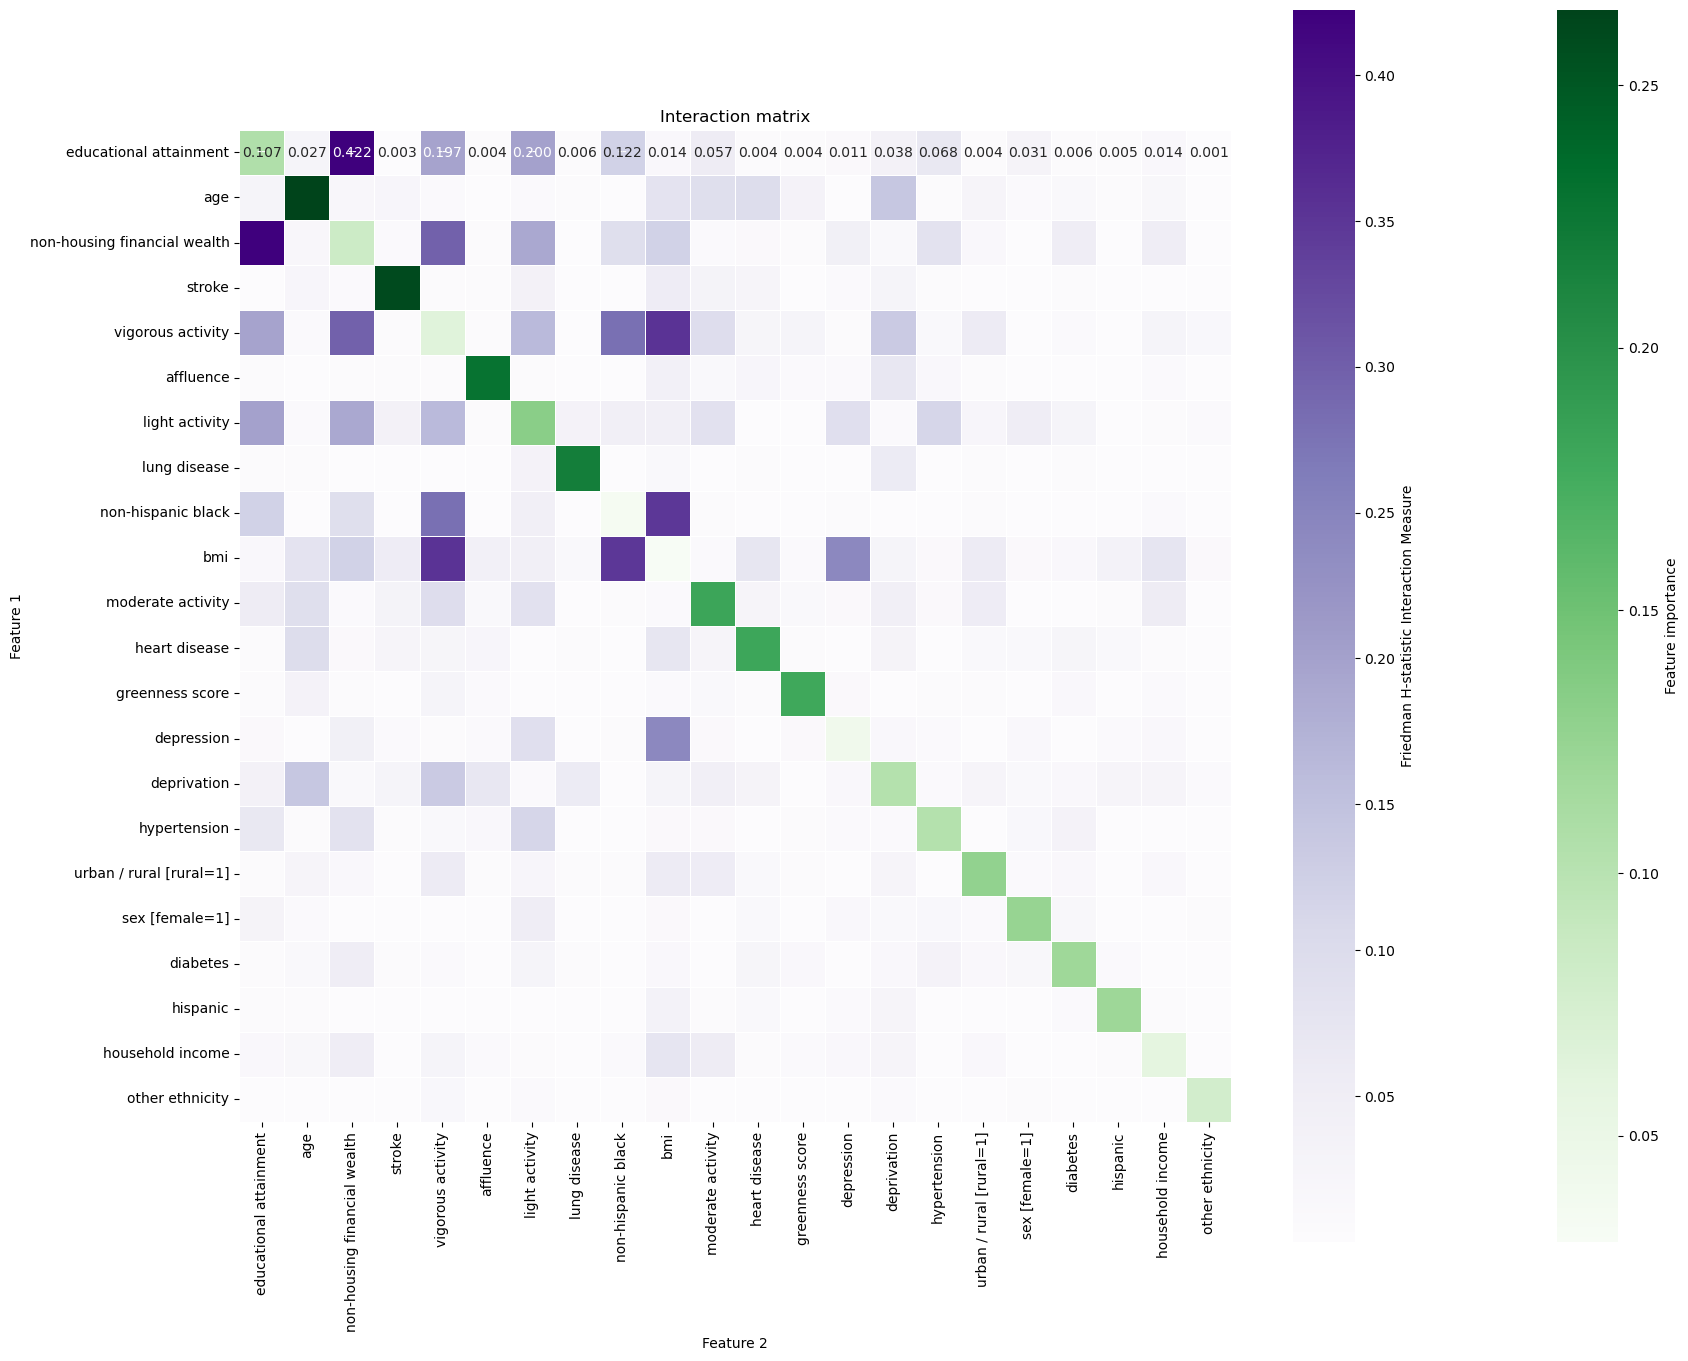

In [ ]:
friedman.plot(vis_type="heatmap", figsize=(20, 20))
ax = plt.gca()
labels = ax.get_yticklabels()
feature_names = ["age", "sex [female=1]", "educational attainment", "household income", "non-housing financial wealth", 
                "bmi", "stroke", "hypertension", "diabetes", "heart disease", "lung disease", "depression", "light activity", "moderate activity", "vigorous activity", 
                "affluence", "deprivation", "urban / rural [rural=1]", "greenness score", "non-hispanic black", "hispanic", "other ethnicity"]
new_labels = [l.get_text() for l in labels]
new_labels = [feature_names[airpol_dataset.interaction_predictors.index(l)] for l in new_labels]
ax.set_yticklabels(new_labels)
ax.set_xticklabels(new_labels)
plt.gcf().savefig(os.path.join(results_dir, "interactions_heatmap_regnn.png"))